# 時系列解析2
https://logics-of-blue.com/python-time-series-analysis/

In [1]:
# 基本のライブラリを読み込む
import numpy as np
import pandas as pd
from scipy import stats

# グラフ描画
from matplotlib import pylab as plt
import seaborn as sns
%matplotlib inline
sns.set()

# グラフを横長にする
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

# 統計モデル
import statsmodels.api as sm

In [8]:
# 以下のコードの方が読み込みは簡単
data = pd.read_csv('AirPassengers.csv', 
                   index_col='Month', 
                   parse_dates=True, 
                   dtype='float')
data.head()

# 日付形式にする
ts = data['#Passengers'] 
ts.head()

Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
Name: #Passengers, dtype: float64

In [9]:
# データの取得方法その1
ts['1949-01-01']

# データの取得方法その2
from datetime import datetime
ts[datetime(1949,1, 1)]

# 1949年のデータをすべて取ってくる
ts['1949']

Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
1949-06-01    135.0
1949-07-01    148.0
1949-08-01    148.0
1949-09-01    136.0
1949-10-01    119.0
1949-11-01    104.0
1949-12-01    118.0
Name: #Passengers, dtype: float64

In [16]:
diff = ts - ts.shift()
diff.head()

Month
1949-01-01     NaN
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
Name: #Passengers, dtype: float64

In [18]:
# 自己相関を求める
ts_acf = sm.tsa.stattools.acf(ts, nlags=40)
ts_acf

array([1.        , 0.94804734, 0.87557484, 0.80668116, 0.75262542,
       0.71376997, 0.6817336 , 0.66290439, 0.65561048, 0.67094833,
       0.70271992, 0.74324019, 0.76039504, 0.71266087, 0.64634228,
       0.58592342, 0.53795519, 0.49974753, 0.46873401, 0.44987066,
       0.4416288 , 0.45722376, 0.48248203, 0.51712699, 0.53218983,
       0.49397569, 0.43772134, 0.3876029 , 0.34802503, 0.31498388,
       0.28849682, 0.27080187, 0.26429011, 0.27679934, 0.2985215 ,
       0.32558712, 0.3370236 , 0.30333486, 0.25397708, 0.21065534,
       0.17217092])

In [19]:
# 偏自己相関
ts_pacf = sm.tsa.stattools.pacf(ts, nlags=40, method='ols')
ts_pacf

array([ 1.        ,  0.95893198, -0.32983096,  0.2018249 ,  0.14500798,
        0.25848232, -0.02690283,  0.20433019,  0.15607896,  0.56860841,
        0.29256358,  0.8402143 ,  0.61268285, -0.66597616, -0.38463943,
        0.0787466 , -0.02663483, -0.05805221, -0.04350748,  0.27732556,
       -0.04046447,  0.13739883,  0.3859958 ,  0.24203808, -0.04912986,
       -0.19599778, -0.15443575,  0.04484465,  0.18371541, -0.0906113 ,
       -0.06202938,  0.34827092,  0.09899499, -0.08396793,  0.36328898,
       -0.17956662,  0.15839435,  0.06376775, -0.27503705,  0.2707607 ,
        0.32002003])

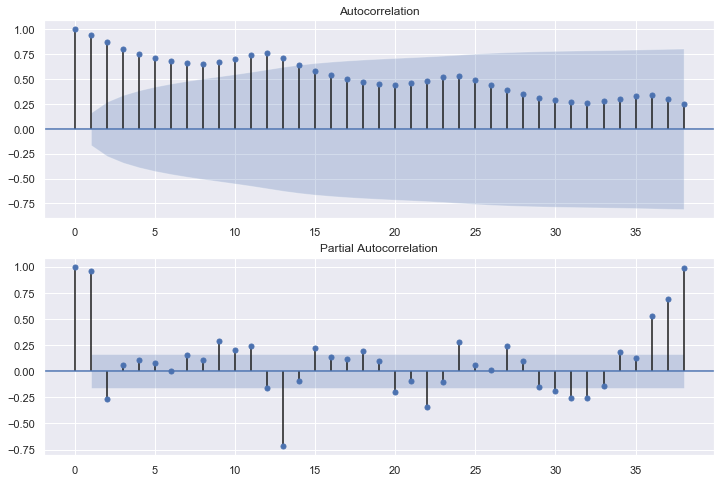

In [21]:
#  自己相関のグラフ
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts, lags=38, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts, lags=38, ax=ax2)

In [22]:
# たぶん和分過程なので、差分をとる
diff = ts - ts.shift()
diff = diff.dropna()

# 差分系列への自動ARMA推定関数の実行
resDiff = sm.tsa.arma_order_select_ic(diff, ic='aic', trend='nc')
resDiff

/Users/mitsuhiro/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/mitsuhiro/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/mitsuhiro/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/mitsuhiro/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/scipy/signal/signaltools.py:1364: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

{'aic':              0            1            2
 0          NaN  1397.257791  1397.093436
 1  1401.852641  1412.615224  1385.496795
 2  1396.587654  1378.338024  1353.175681
 3  1395.021214  1379.614000  1351.138822
 4  1388.216680  1379.616584  1373.560615, 'aic_min_order': (3, 2)}

In [23]:
# P-3, q=2 が最善となったので、それをモデル化
from statsmodels.tsa.arima_model import ARIMA
ARIMA_3_1_2 = ARIMA(ts, order=(3, 1, 2)).fit(dist=False)
ARIMA_3_1_2.params

/Users/mitsuhiro/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/mitsuhiro/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


const                  2.673517
ar.L1.D.#Passengers    0.261983
ar.L2.D.#Passengers    0.367820
ar.L3.D.#Passengers   -0.363477
ma.L1.D.#Passengers   -0.075081
ma.L2.D.#Passengers   -0.924879
dtype: float64

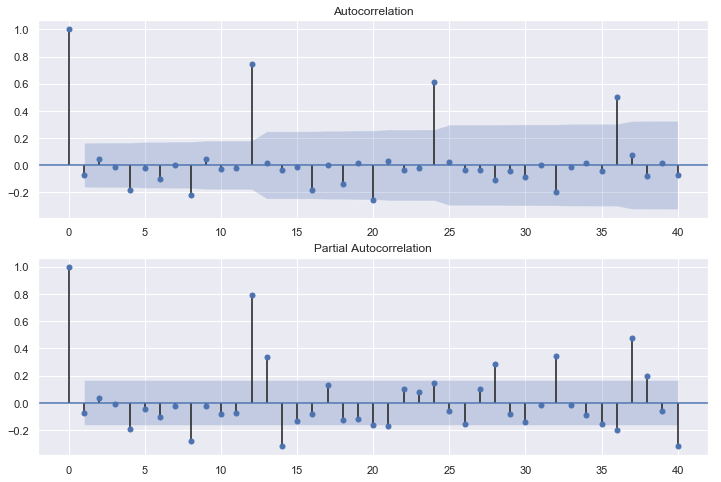

In [24]:
# 残差のチェック
# SARIMAじゃないので、周期性が残ってしまっている。。。
resid = ARIMA_3_1_2.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

In [25]:
# SARIMAモデルを「決め打ち」で推定する
import statsmodels.api as sm

SARIMA_3_1_2_111 = sm.tsa.SARIMAX(ts, order=(3,1,2), seasonal_order=(1,1,1,12)).fit()
print(SARIMA_3_1_2_111.summary())

/Users/mitsuhiro/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                        #Passengers   No. Observations:                  144
Model:             SARIMAX(3, 1, 2)x(1, 1, 1, 12)   Log Likelihood                -502.966
Date:                            Tue, 12 Mar 2019   AIC                           1021.931
Time:                                    14:52:58   BIC                           1044.933
Sample:                                01-01-1949   HQIC                          1031.278
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7013      1.551      0.452      0.651      -2.338       3.741
ar.L2          0.1910      0.925   

/Users/mitsuhiro/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


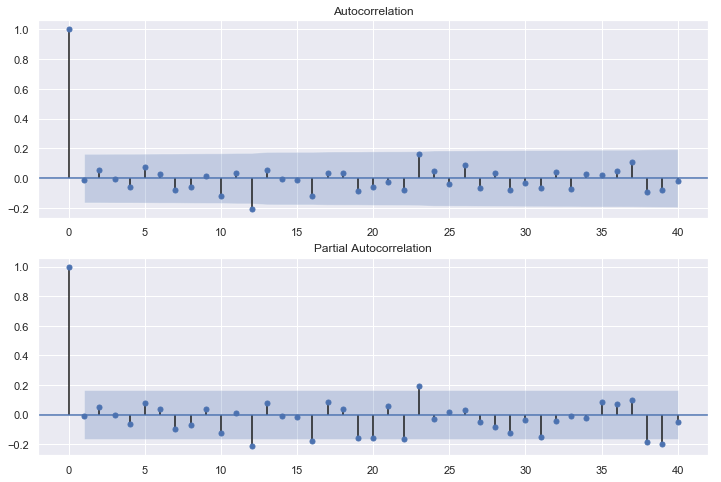

In [27]:
# 残差のチェック
residSARIMA = SARIMA_3_1_2_111.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residSARIMA.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residSARIMA, lags=40, ax=ax2)

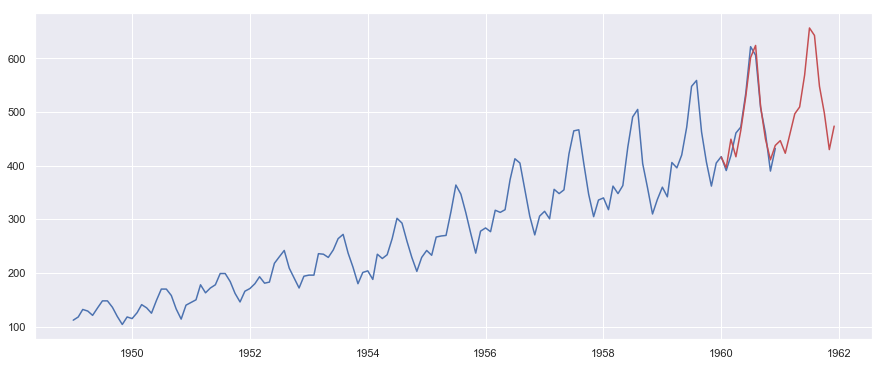

In [28]:
# 予測
pred = SARIMA_3_1_2_111.predict('1960-01-01', '1961-12-01')

# 実データと予測結果の図示
plt.plot(ts)
plt.plot(pred, "r")

In [29]:
# 総当たりで、AICが最小となるSARIMAの次数を探す
max_p = 3
max_q = 3
max_d = 1
max_sp = 1
max_sq = 1
max_sd = 1

pattern = max_p*(max_q + 1)*(max_d + 1)*(max_sp + 1)*(max_sq + 1)*(max_sd + 1)

modelSelection = pd.DataFrame(index=range(pattern), columns=["model", "aic"])
pattern

192

In [30]:
# 自動SARIMA選択
num = 0

for p in range(1, max_p + 1):
    for d in range(0, max_d + 1):
        for q in range(0, max_q + 1):
            for sp in range(0, max_sp + 1):
                for sd in range(0, max_sd + 1):
                    for sq in range(0, max_sq + 1):
                        sarima = sm.tsa.SARIMAX(
                            ts, order=(p,d,q), 
                            seasonal_order=(sp,sd,sq,12), 
                            enforce_stationarity = False, 
                            enforce_invertibility = False
                        ).fit()
                        modelSelection.ix[num]["model"] = "order=(" + str(p) + ","+ str(d) + ","+ str(q) + "), season=("+ str(sp) + ","+ str(sd) + "," + str(sq) + ")"
                        modelSelection.ix[num]["aic"] = sarima.aic
                        num = num + 1

/Users/mitsuhiro/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/mitsuhiro/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/mitsuhiro/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/mitsuhiro/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for p

In [31]:
# AIC最小モデル
modelSelection[modelSelection.aic == min(modelSelection.aic)]

,model,aic
187,"order=(3,1,3), season=(0,1,1)",898.105


In [32]:
bestSARIMA = sm.tsa.SARIMAX(ts, order=(3,1,3), seasonal_order=(0,1,1,12), enforce_stationarity = False, enforce_invertibility = False).fit()

print(bestSARIMA.summary())

/Users/mitsuhiro/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                        #Passengers   No. Observations:                  144
Model:             SARIMAX(3, 1, 3)x(0, 1, 1, 12)   Log Likelihood                -441.052
Date:                            Tue, 12 Mar 2019   AIC                            898.105
Time:                                    15:00:18   BIC                            920.064
Sample:                                01-01-1949   HQIC                           907.018
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2231      0.097     -2.302      0.021      -0.413      -0.033
ar.L2         -0.1642      0.108   

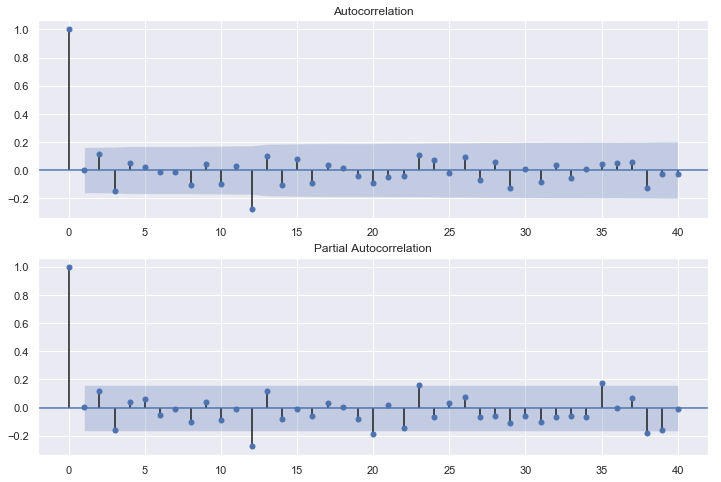

In [33]:
# 残差のチェック
residSARIMA = bestSARIMA.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residSARIMA, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residSARIMA, lags=40, ax=ax2)

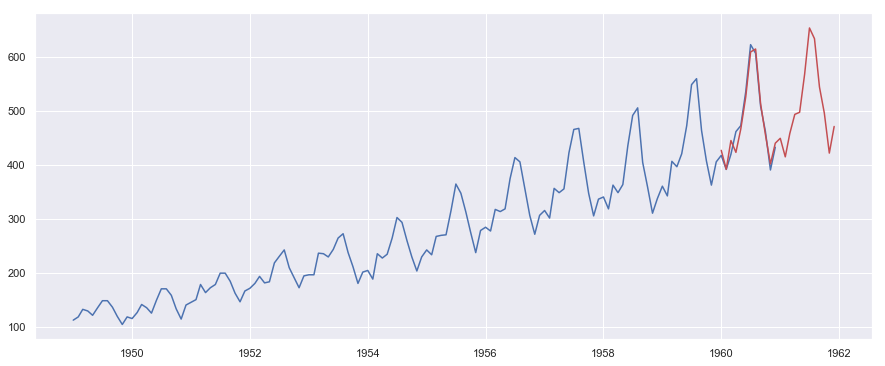

In [34]:
# 予測
bestPred = bestSARIMA.predict('1960-01-01', '1961-12-01')
# 実データと予測結果の図示
plt.plot(ts)
plt.plot(bestPred, "r")